In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import tensorflow.keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [2]:
# 얼리스탑핑 쉽게
def model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, patience):
    save_file_name = model_name
    cb_checkpoint,cb_earlystopping = checkpoint_ez(MODEL_SAVE_FOLDER_PATH, save_file_name, patience)
    return cb_checkpoint,cb_earlystopping

def checkpoint_ez(MODEL_SAVE_FOLDER_PATH,save_file_name, patience) : 
    MODEL_SAVE_FOLDER_PATH = MODEL_SAVE_FOLDER_PATH
    data_name = save_file_name
    model_path = MODEL_SAVE_FOLDER_PATH + data_name + '.hdf5'
    # val_loss 값이 낮아졌을(좋아졌을) 때만 저장
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True
                                   )
    cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience = patience, verbose=1,
                                                  mode='auto', baseline=None, restore_best_weights=False)
    return cb_checkpoint, cb_earlystopping

# 그래프 쉽게
def loss_graph(label1,label2,bottom,top):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label=label1)
    loss_ax.plot(history.history['val_loss'], 'r', label=label2)
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    # acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    loss_ax.set_ylim(bottom,top)
    return plt.show()

# 모델 저장 def
def json_model_saver(MODEL_SAVE_FOLDER_PATH,file_name):
    # model save by json
    # load model 
    model = keras.models.load_model(MODEL_SAVE_FOLDER_PATH +file_name+ '.hdf5')
    # Save model with json format
    model_json = model.to_json()
    with open(MODEL_SAVE_FOLDER_PATH+file_name+'.json', "w") as json_file:
        json_file.write(model_json)
    # Save weight with h5 format
    model.save_weights( MODEL_SAVE_FOLDER_PATH +file_name +'.h5')
    return print("Saved model to disk : "+ file_name +'.h5')


In [171]:
# 데이터 불러오기
path_AL = '../9.data/0.work_data/3.Accident_list/'

AccList_accident = pd.read_csv(path_AL + 'AccList_accident.csv', header=None, index_col=0)
AccList_pattern = pd.read_csv(path_AL + 'AccList_pattern.csv', header=None, index_col=0)

In [172]:
AccList_accident = AccList_accident.reset_index()
AccList_accident = AccList_accident.reset_index(0, drop = False)
AccList_accident = AccList_accident.set_index(0, drop = True)

AccList_pattern = AccList_pattern.reset_index()
AccList_pattern = AccList_pattern.reset_index(0, drop = True)

In [173]:
# Accident, Nonaccident 리스트 불러오기
diff_path = '../9.data/1.accData_split/1.diff_heatmap/'
acclist = os.listdir(diff_path + 'accident/')
nonacclist = os.listdir(diff_path + 'nonaccident/')

for i in range(len(acclist)):
    acclist[i] = acclist[i].split('.')[0]
accData = AccList_accident.loc[acclist]
pattData = AccList_pattern.loc[accData.set_index('index').index]

for i in range(len(nonacclist)):
    nonacclist[i] = nonacclist[i].split('.')[0]
nonAccData = AccList_accident.loc[nonacclist]
nonPattData = AccList_pattern.loc[nonAccData.set_index('index').index]

In [174]:
del accData['index']
pattData = pattData.set_index(0, drop = True)

del nonAccData['index']
nonPattData = nonPattData.set_index(0, drop = True)

In [175]:
accData['y'] = 1
nonAccData['y'] = 0
data1 = pd.concat([accData, nonAccData])
data2 = pd.concat([pattData, nonPattData])

In [176]:
# 데이터 섞은 후 배열로 만들기

np.random.seed(0)
randomList = list(np.random.randint(2000, size = 2000))
data1 = data1.reset_index(drop=True)
data1 = data1.loc[randomList]
data1 = data1.reset_index(drop=True)
data2 = data2.reset_index(drop=True)
data2 = data2.loc[randomList]
data2 = data2.reset_index(drop=True)

In [177]:
print(data1.max().max())
print(data2.max().max())

143.0
108.16129032258064


In [178]:
# dataX = data1.T[:-1].T
# dataX = dataX/143
# data2 = data2/143
# dataX = np.expand_dims(dataX, 1)
# data2 = np.expand_dims(data2, 1)
# dataX = np.concatenate((dataX, data2), axis=1)

# dataY = data1['y']

dataX = data1.T[:-1].T
dataX = dataX/143
data2 = data2/143
dataX = np.expand_dims(dataX, -1)
data2 = np.expand_dims(data2, -1)
dataX = np.concatenate((dataX, data2), axis=2)

dataY = data1['y']

In [179]:
dataX = np.array(dataX)
dataY = dataY.array

# input data 생성
nTrain = 1500
nTest = 500

x_train = dataX[:nTrain, :561]
x_test = dataX[:nTest, :561]
y_train = dataY[:nTrain]
y_test = dataY[:nTest]

In [180]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [181]:
# # 데이터 reshape
# x_train = x_train.reshape(x_train.shape[0],2,51,11)
# x_test = x_test.reshape(x_test.shape[0],2,51,11)

# 데이터 reshape
x_train = x_train.reshape(x_train.shape[0],51,11,2)
x_test = x_test.reshape(x_test.shape[0],51,11,2)

AxesImage(54,36;334.8x217.44)
0    0
1    1
Name: 100, dtype: uint8


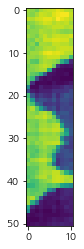

In [167]:
n = 100
print(plt.imshow(x_train[n][0][:][:]))
#print(plt.imshow(x_train[n][1][:][:]))
print(y_train[:].iloc[n])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 9, 8)          152       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 4, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7690      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 7,864
Trainable params: 7,864
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6943 - accuracy: 0.4901
Epoch 00001: val_loss 

117/120 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4795
Epoch 00026: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4767 - val_loss: 0.6922 - val_accuracy: 0.5467
Epoch 27/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.4875
Epoch 00027: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4800 - val_loss: 0.6921 - val_accuracy: 0.5467
Epoch 28/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4875
Epoch 00028: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4533
Epoch 29/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5071
Epoch 00029: val_loss did not improve from 0.69077
120/120 [============

107/120 [=========================>....] - ETA: 0s - loss: 0.6936 - accuracy: 0.4860
Epoch 00055: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4800 - val_loss: 0.6925 - val_accuracy: 0.5467
Epoch 56/1000
117/120 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.4957
Epoch 00056: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6925 - val_accuracy: 0.5467
Epoch 57/1000
119/120 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000
Epoch 00057: val_loss did not improve from 0.69077
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.4533
Epoch 58/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5000
Epoch 00058: val_loss did not improve from 0.69077
120/120 [============

112/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4705
Epoch 00084: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4733 - val_loss: 0.6926 - val_accuracy: 0.5467
Epoch 85/1000
118/120 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.4856
Epoch 00085: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4850 - val_loss: 0.6934 - val_accuracy: 0.4533
Epoch 86/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.4795
Epoch 00086: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4833 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 87/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.4973
Epoch 00087: val_loss did not improve from 0.69000
120/120 [============

109/120 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5046
Epoch 00113: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5083 - val_loss: 0.6921 - val_accuracy: 0.5467
Epoch 114/1000
118/120 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4958
Epoch 00114: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4933 - val_loss: 0.6943 - val_accuracy: 0.4533
Epoch 115/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5088
Epoch 00115: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5067 - val_loss: 0.6912 - val_accuracy: 0.5467
Epoch 116/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5009
Epoch 00116: val_loss did not improve from 0.69000
120/120 [=========

110/120 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5045
Epoch 00142: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6915 - val_accuracy: 0.5467
Epoch 143/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5009
Epoch 00143: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6948 - val_accuracy: 0.4533
Epoch 144/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.4918
Epoch 00144: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5467
Epoch 145/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5082
Epoch 00145: val_loss did not improve from 0.69000
120/120 [=========

115/120 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.4852
Epoch 00171: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4817 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 172/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5061
Epoch 00172: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 173/1000
116/120 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4957
Epoch 00173: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4917 - val_loss: 0.6954 - val_accuracy: 0.4533
Epoch 174/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5009
Epoch 00174: val_loss did not improve from 0.69000
120/120 [=========

111/120 [==========================>...] - ETA: 0s - loss: 0.6940 - accuracy: 0.4937
Epoch 00200: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5467
Epoch 201/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4939
Epoch 00201: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4917 - val_loss: 0.6939 - val_accuracy: 0.4533
Epoch 202/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6941 - accuracy: 0.4927
Epoch 00202: val_loss did not improve from 0.69000
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4917 - val_loss: 0.6922 - val_accuracy: 0.5467
Epoch 203/1000
116/120 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.4974
Epoch 00203: val_loss did not improve from 0.69000
120/120 [=========

Epoch 229/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.4955
Epoch 00229: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4983 - val_loss: 0.6936 - val_accuracy: 0.4533
Epoch 230/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4973
Epoch 00230: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4917 - val_loss: 0.6915 - val_accuracy: 0.5467
Epoch 231/1000
117/120 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.4744
Epoch 00231: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4750 - val_loss: 0.6933 - val_accuracy: 0.4533
Epoch 232/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4974
Epoch 00232: val_loss did not improve from 0.68994
120

117/120 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.4923
Epoch 00258: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4917 - val_loss: 0.6937 - val_accuracy: 0.4533
Epoch 259/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.4936
Epoch 00259: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 260/1000
106/120 [=========================>....] - ETA: 0s - loss: 0.6935 - accuracy: 0.4887
Epoch 00260: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4883 - val_loss: 0.6930 - val_accuracy: 0.5467
Epoch 261/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.4921
Epoch 00261: val_loss did not improve from 0.68994
120/120 [=========

110/120 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.4818
Epoch 00287: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4850 - val_loss: 0.6926 - val_accuracy: 0.5467
Epoch 288/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.4928
Epoch 00288: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6912 - val_accuracy: 0.5467
Epoch 289/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.4843
Epoch 00289: val_loss did not improve from 0.68994
120/120 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4850 - val_loss: 0.6915 - val_accuracy: 0.5467
Epoch 290/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.4830
Epoch 00290: val_loss did not improve from 0.68994
120/120 [=========

Epoch 316/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.4948
Epoch 00316: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4533
Epoch 317/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.5053
Epoch 00317: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5017 - val_loss: 0.6946 - val_accuracy: 0.4533
Epoch 318/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4904
Epoch 00318: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 319/1000
119/120 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4849
Epoch 00319: val_loss did not improve from 0.68990
120

106/120 [=========================>....] - ETA: 0s - loss: 0.6939 - accuracy: 0.5019
Epoch 00345: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4967 - val_loss: 0.6937 - val_accuracy: 0.4533
Epoch 346/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4817
Epoch 00346: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4833 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 347/1000
108/120 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.4972
Epoch 00347: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4933 - val_loss: 0.6918 - val_accuracy: 0.5467
Epoch 348/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.4964
Epoch 00348: val_loss did not improve from 0.68990
120/120 [=========

113/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.4982
Epoch 00374: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4967 - val_loss: 0.6947 - val_accuracy: 0.4533
Epoch 375/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4646
Epoch 00375: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4633 - val_loss: 0.6932 - val_accuracy: 0.4533
Epoch 376/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6935 - accuracy: 0.4888
Epoch 00376: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4833 - val_loss: 0.6923 - val_accuracy: 0.5467
Epoch 377/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4858
Epoch 00377: val_loss did not improve from 0.68990
120/120 [=========

109/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.4954
Epoch 00403: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 404/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6946 - accuracy: 0.4785
Epoch 00404: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4767 - val_loss: 0.6937 - val_accuracy: 0.4533
Epoch 405/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4878
Epoch 00405: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4883 - val_loss: 0.6935 - val_accuracy: 0.4533
Epoch 406/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6936 - accuracy: 0.5019
Epoch 00406: val_loss did not improve from 0.68990
120/120 [=========

109/120 [==========================>...] - ETA: 0s - loss: 0.6941 - accuracy: 0.4826
Epoch 00432: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4833 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 433/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4955
Epoch 00433: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4967 - val_loss: 0.6951 - val_accuracy: 0.4533
Epoch 434/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5009
Epoch 00434: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5467
Epoch 435/1000
119/120 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.4765
Epoch 00435: val_loss did not improve from 0.68990
120/120 [=========

115/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.4765
Epoch 00461: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4767 - val_loss: 0.6923 - val_accuracy: 0.5467
Epoch 462/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4887
Epoch 00462: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4883 - val_loss: 0.6939 - val_accuracy: 0.4533
Epoch 463/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4632
Epoch 00463: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4633 - val_loss: 0.6937 - val_accuracy: 0.4533
Epoch 464/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.4791
Epoch 00464: val_loss did not improve from 0.68990
120/120 [=========

111/120 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5018
Epoch 00490: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4967 - val_loss: 0.6918 - val_accuracy: 0.5467
Epoch 491/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5000
Epoch 00491: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6925 - val_accuracy: 0.5467
Epoch 492/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5110
Epoch 00492: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5067 - val_loss: 0.6947 - val_accuracy: 0.4533
Epoch 493/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6939 - accuracy: 0.4835
Epoch 00493: val_loss did not improve from 0.68990
120/120 [=========

112/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4946
Epoch 00519: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4967 - val_loss: 0.6943 - val_accuracy: 0.4533
Epoch 520/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6940 - accuracy: 0.4936
Epoch 00520: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5017 - val_loss: 0.6955 - val_accuracy: 0.4533
Epoch 521/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.4877
Epoch 00521: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4800 - val_loss: 0.6933 - val_accuracy: 0.4533
Epoch 522/1000
117/120 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5060
Epoch 00522: val_loss did not improve from 0.68990
120/120 [=========

112/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.4554
Epoch 00548: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4600 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 549/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.4875
Epoch 00549: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4933 - val_loss: 0.6926 - val_accuracy: 0.5467
Epoch 550/1000
108/120 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.4833
Epoch 00550: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4767 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 551/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.4956
Epoch 00551: val_loss did not improve from 0.68990
120/120 [=========

110/120 [==========================>...] - ETA: 0s - loss: 0.6940 - accuracy: 0.4882
Epoch 00577: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4817 - val_loss: 0.6918 - val_accuracy: 0.5467
Epoch 578/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.4743
Epoch 00578: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4733 - val_loss: 0.6917 - val_accuracy: 0.5467
Epoch 579/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.4781
Epoch 00579: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4767 - val_loss: 0.6932 - val_accuracy: 0.4533
Epoch 580/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4912
Epoch 00580: val_loss did not improve from 0.68990
120/120 [=========

113/120 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5044
Epoch 00606: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6912 - val_accuracy: 0.5467
Epoch 607/1000
106/120 [=========================>....] - ETA: 0s - loss: 0.6940 - accuracy: 0.4811
Epoch 00607: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4800 - val_loss: 0.6910 - val_accuracy: 0.5467
Epoch 608/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.4903
Epoch 00608: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4883 - val_loss: 0.6929 - val_accuracy: 0.5467
Epoch 609/1000
118/120 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4831
Epoch 00609: val_loss did not improve from 0.68990
120/120 [=========

Epoch 635/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5027
Epoch 00635: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6937 - val_accuracy: 0.4533
Epoch 636/1000
117/120 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.4829
Epoch 00636: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4850 - val_loss: 0.6923 - val_accuracy: 0.5467
Epoch 637/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5045
Epoch 00637: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5017 - val_loss: 0.6924 - val_accuracy: 0.5467
Epoch 638/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5045
Epoch 00638: val_loss did not improve from 0.68990
120

108/120 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.4843
Epoch 00664: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4800 - val_loss: 0.6935 - val_accuracy: 0.4533
Epoch 665/1000
112/120 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.4866
Epoch 00665: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4883 - val_loss: 0.6920 - val_accuracy: 0.5467
Epoch 666/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6935 - accuracy: 0.4963
Epoch 00666: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4933 - val_loss: 0.6920 - val_accuracy: 0.5467
Epoch 667/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6939 - accuracy: 0.4712
Epoch 00667: val_loss did not improve from 0.68990
120/120 [=========

106/120 [=========================>....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4792
Epoch 00693: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4833 - val_loss: 0.6940 - val_accuracy: 0.4533
Epoch 694/1000
116/120 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5034
Epoch 00694: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5067 - val_loss: 0.6912 - val_accuracy: 0.5467
Epoch 695/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6945 - accuracy: 0.4946
Epoch 00695: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6945 - accuracy: 0.4867 - val_loss: 0.6929 - val_accuracy: 0.5467
Epoch 696/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5037
Epoch 00696: val_loss did not improve from 0.68990
120/120 [=========

116/120 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4983
Epoch 00722: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6920 - val_accuracy: 0.5467
Epoch 723/1000
115/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.5026
Epoch 00723: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.4533
Epoch 724/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4807
Epoch 00724: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4817 - val_loss: 0.6940 - val_accuracy: 0.4533
Epoch 725/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6937 - accuracy: 0.4881
Epoch 00725: val_loss did not improve from 0.68990
120/120 [=========

114/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4816
Epoch 00751: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4867 - val_loss: 0.6926 - val_accuracy: 0.5467
Epoch 752/1000
111/120 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.4883
Epoch 00752: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4917 - val_loss: 0.6924 - val_accuracy: 0.5467
Epoch 753/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.4894
Epoch 00753: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4900 - val_loss: 0.6935 - val_accuracy: 0.4533
Epoch 754/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.4882
Epoch 00754: val_loss did not improve from 0.68990
120/120 [=========

114/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4895
Epoch 00780: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6933 - val_accuracy: 0.4533
Epoch 781/1000
114/120 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4886
Epoch 00781: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4867 - val_loss: 0.6921 - val_accuracy: 0.5467
Epoch 782/1000
116/120 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4879
Epoch 00782: val_loss did not improve from 0.68990
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4833 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 783/1000
113/120 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4885
Epoch 00783: val_loss did not improve from 0.68990
120/120 [=========

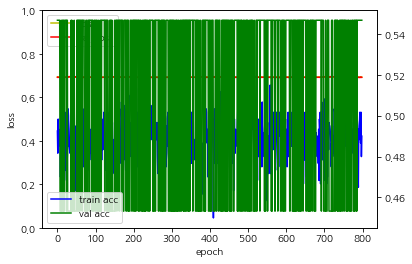

In [184]:
model_name = 'test'
MODEL_SAVE_FOLDER_PATH = '../1.model'
cb_checkpoint,cb_earlystopping = model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, 500)

tf.keras.backend.clear_session()


model = Sequential()
model.add(layers.Conv2D(filters=8, kernel_size = 3 , input_shape=(51,11,2), activation='relu', kernel_initializer='he_normal')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=10, activation='relu', kernel_initializer='he_normal')) 
model.add(layers.Dense(units=2, activation='sigmoid'))
model.compile(loss ='binary_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, shuffle=True,epochs=1000, batch_size=10, validation_split=0.2, callbacks=[cb_checkpoint,cb_earlystopping])
loss_graph('loss','val_loss',0,1)

In [186]:
loss, acc = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4780


In [198]:
y_test

,0.0,1.0
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
495,1,0
496,1,0
497,0,1
498,1,0


In [207]:
import matplotlib.pyplot as plt

plt.imshow(test[10])

NameError: name 'test' is not defined

In [121]:
test[0].shape

(51, 11)

In [120]:
img.shape

(1670, 2400, 3)

In [78]:
accPath = '../9.data/1.accData_split/1.diff_heatmap/accident/'
nonaccPath = '../9.data/1.accData_split/1.diff_heatmap/nonaccident/'

acc_list = os.listdir(accPath)
nonacc_list = os.listdir(nonaccPath)

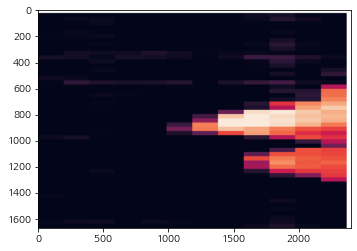

In [122]:
img = cv2.imread(accPath + acc_list[50])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [102]:
num = 0
for i in acc_list:    
    if num == 0:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_train = np.expand_dims(img, 0)
        num += 1
    else:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, 0)
        x_train = np.concatenate((x_train, img), axis=0)


KeyboardInterrupt: 

TypeError: Invalid shape (1, 1670, 2400, 3) for image data

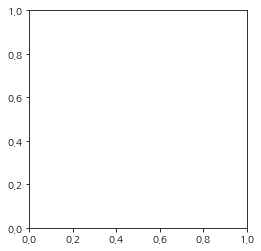

In [103]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [113]:
img = cv2.imread(accPath + acc_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)